In [1]:
import sys
import pandas
import konlpy
import gensim
import numpy as np
import tensorflow as tf

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)
print(sys.version)
print(np.__version__)
print(tf.__version__)

1.3.3
0.5.2
4.1.2
3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) 
[GCC 9.4.0]
1.21.4
2.6.0


In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # [[YOUR CODE]]
    # 중복값 제거
    train_data = train_data.drop_duplicates(subset=['document'])
    test_data = test_data.drop_duplicates(subset=['document'])

    # NaN 결측치 제거
    train_data = train_data.dropna(how = 'any')
    test_data = test_data.dropna(how = 'any')

    # 한국어 토크나이저로 토큰화
    # 불용어(Stopwords) 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    # 사전word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    # 텍스트 스트링을 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    # X_train, y_train, X_test, y_test, word_to_index 리턴
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
# 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [30]:
len(index_to_word)

10000

In [6]:
print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
# print(word_to_index['the'])  # 4 이 출력됩니다. 
print(index_to_word[4])     # 'the' 가 출력됩니다.

<BOS>
.


In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [8]:
# 3) 모델 구성을 위한 데이터 분석 및 가공
# 데이터셋 내 문장 길이 분포
# 적절한 최대 문장 길이 지정
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [9]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [10]:
X_train

array([[  32,   74,  919, ...,    0,    0,    0],
       [1028,    4,   11, ...,    0,    0,    0],
       [  24,  205,    3, ...,    0,    0,    0],
       ...,
       [ 154,    3,   18, ...,    0,    0,    0],
       [1052,    5, 2516, ...,    0,    0,    0],
       [ 181,    5, 1945, ...,    0,    0,    0]], dtype=int32)

In [12]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
# [[YOUR CODE]]
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 16로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [19]:
X_train.shape[0]*0.2

29236.4

In [20]:
# validation set 10000건 분리
val_index_num = 29236
X_val = X_train[:val_index_num]   
y_val = y_train[:val_index_num]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[val_index_num:]  
partial_y_train = y_train[val_index_num:]

print(partial_X_train.shape)
print(partial_y_train.shape)
print(X_val.shape)
print(y_val.shape)

(116946, 41)
(116946,)
(29236, 41)
(29236,)


In [23]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/50
229/229 [==============================] - 5s 8ms/step - loss: 0.6474 - accuracy: 0.5779 - val_loss: 0.4398 - val_accuracy: 0.8228
Epoch 2/50
229/229 [==============================] - 1s 6ms/step - loss: 0.3721 - accuracy: 0.8427 - val_loss: 0.3450 - val_accuracy: 0.8504
Epoch 3/50
229/229 [==============================] - 1s 6ms/step - loss: 0.3211 - accuracy: 0.8646 - val_loss: 0.3434 - val_accuracy: 0.8506
Epoch 4/50
229/229 [==============================] - 1s 6ms/step - loss: 0.3006 - accuracy: 0.8720 - val_loss: 0.3434 - val_accuracy: 0.8513
Epoch 5/50
229/229 [==============================] - 1s 6ms/step - loss: 0.2872 - accuracy: 0.8769 - val_loss: 0.3536 - val_accuracy: 0.8502
Epoch 6/50
229/229 [==============================] - 1s 6ms/step - loss: 0.2758 - accuracy: 0.8796 - val_loss: 0.3627 - val_accuracy: 0.8491
Epoch 7/50
229/229 [==============================] - 1s 6ms/step - loss: 0.2645 - accuracy: 0.8841 - val_loss: 0.3786 - val_accuracy: 0.8478
Epoch 

In [25]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.6314 - accuracy: 0.8234
[0.6313573718070984, 0.823361873626709]


In [26]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


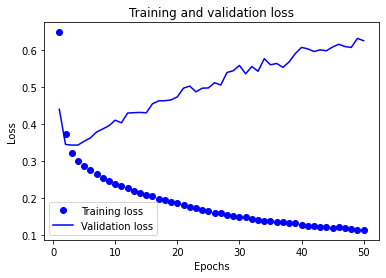

In [27]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

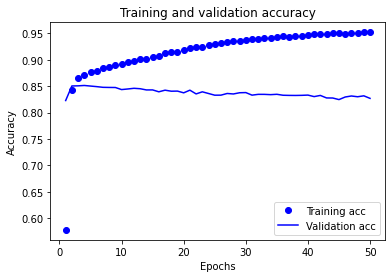

In [28]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [31]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          11216     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [32]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/50
229/229 [==============================] - 4s 7ms/step - loss: 0.4543 - accuracy: 0.7849 - val_loss: 0.3500 - val_accuracy: 0.8494
Epoch 2/50
229/229 [==============================] - 1s 6ms/step - loss: 0.3148 - accuracy: 0.8678 - val_loss: 0.3335 - val_accuracy: 0.8556
Epoch 3/50
229/229 [==============================] - 1s 5ms/step - loss: 0.2686 - accuracy: 0.8916 - val_loss: 0.3387 - val_accuracy: 0.8548
Epoch 4/50
229/229 [==============================] - 1s 5ms/step - loss: 0.2152 - accuracy: 0.9172 - val_loss: 0.3644 - val_accuracy: 0.8511
Epoch 5/50
229/229 [==============================] - 2s 7ms/step - loss: 0.1581 - accuracy: 0.9426 - val_loss: 0.4010 - val_accuracy: 0.8495
Epoch 6/50
229/229 [==============================] - 1s 5ms/step - loss: 0.1108 - accuracy: 0.9626 - val_loss: 0.4593 - val_accuracy: 0.8426
Epoch 7/50
229/229 [==============================] - 1s 6ms/step - loss: 0.0767 - accuracy: 0.9753 - val_loss: 0.5461 - val_accuracy: 0.8388
Epoch 

In [33]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

history_dict = history.history

1537/1537 - 3s - loss: 1.6512 - accuracy: 0.8230
[1.6512484550476074, 0.8229550123214722]


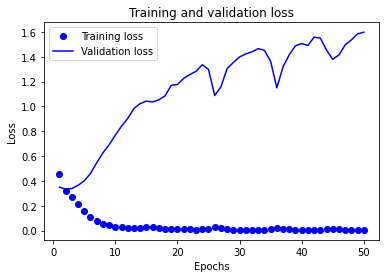

In [34]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

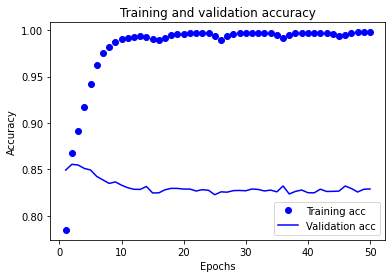

In [35]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [36]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/50
229/229 [==============================] - 2s 5ms/step - loss: 0.5318 - accuracy: 0.7911 - val_loss: 0.3675 - val_accuracy: 0.8401
Epoch 2/50
229/229 [==============================] - 1s 4ms/step - loss: 0.3332 - accuracy: 0.8576 - val_loss: 0.3380 - val_accuracy: 0.8516
Epoch 3/50
229/229 [==============================] - 1s 4ms/step - loss: 0.2861 - accuracy: 0.8817 - val_loss: 0.3382 - val_accuracy: 0.8539
Epoch 4/50
229/229 [==============================] - 1s 4ms/step - loss: 0.2527 - accuracy: 0.8982 - val_loss: 0.3457 - val_accuracy: 0.8545
Epoch 5/50
229/229 [==============================] - 1s 4ms/step - loss: 0.2223 - accuracy: 0.9133 - val_loss: 0.3590 - val_accuracy: 0.8525
Epoch 6/50
229/229 [==============================] - 1s 4ms/step - loss: 0.1932 - accuracy: 0.9272 - val_loss: 0.3772 - val_accuracy: 0.8508
Epoch 7/50
229/229 [==============================] - 1s 4ms/step - loss: 0.1643 - accuracy: 0.9416 - val_loss: 0.4032 - val_accuracy: 0.8483
Epoch 

In [38]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

history_dict = history.history

1537/1537 - 2s - loss: 1.3856 - accuracy: 0.8197
[1.3856348991394043, 0.8196797966957092]


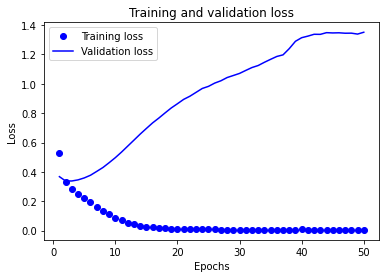

In [39]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

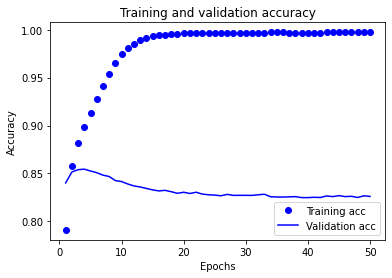

In [40]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [41]:
# 임베딩 확인하기

In [42]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


In [44]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = './word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [45]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['남자']
vector

array([-0.15656903, -0.12080969, -0.14309293,  0.0065707 ,  0.11433759,
       -0.00356212, -0.2298048 , -0.18204384, -0.18869828, -0.18627734,
       -0.13757692, -0.14338979, -0.19737834,  0.05912242, -0.08301815,
       -0.16675116,  0.02008567, -0.19890086, -0.2496661 , -0.1609511 ,
       -0.08648667, -0.20317975, -0.16844966, -0.1840131 , -0.06525449,
        0.02023213, -0.00724943, -0.13029334,  0.04117293, -0.2087799 ,
       -0.16581817,  0.04955156, -0.0274128 , -0.10710271, -0.04296631,
       -0.15933459, -0.06348932, -0.1218341 ,  0.13367403, -0.08146241,
       -0.15689102, -0.05347333, -0.14472474, -0.04467618, -0.14112405,
       -0.15705585,  0.06730295, -0.06907029, -0.17457783, -0.12894818,
       -0.01892544,  0.03005448, -0.20951796,  0.14312406,  0.00141978,
       -0.06177883, -0.18545038, -0.14576799, -0.11687167, -0.02317187,
        0.05510384,  0.31776398, -0.16448617, -0.0150817 , -0.18507856,
       -0.01059604, -0.08979318, -0.16201743, -0.00360079, -0.04

In [46]:
word_vectors.similar_by_word("남자")

[('스러운', 0.7396692633628845),
 ('고', 0.724761962890625),
 ('진짜', 0.6945232152938843),
 ('듯', 0.6847856044769287),
 ('것', 0.6831396818161011),
 ('분위기', 0.6831324696540833),
 ('느낌', 0.6807290315628052),
 ('여서', 0.668145477771759),
 ('영화', 0.6648752093315125),
 ('스타일', 0.6568788290023804)]

In [52]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_file_path = './word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [53]:
vector.shape

(100,)

In [64]:
word_vectors.wv.most_similar(positive=['남자'], topn=5)

[('여자', 0.8692399263381958),
 ('엄마', 0.6886189579963684),
 ('남녀', 0.6824600100517273),
 ('친구', 0.672494649887085),
 ('소녀', 0.6496212482452393)]

In [65]:
print(word_vectors.wv)

In [66]:
# 프리트레인드 임베딩 불러와서 모델링하기

In [69]:
word_vectors.wv.index_to_key

['.',
 '의',
 '다',
 '이',
 '는',
 '/',
 '="',
 ',',
 '에',
 '을',
 '"',
 '하',
 'doc',
 '은',
 ')',
 '(',
 '년',
 '를',
 '고',
 '에서',
 '있',
 ':',
 '으로',
 '가',
 '?',
 '=',
 'https',
 'org',
 'id',
 'title',
 'wiki',
 'wikipedia',
 'ko',
 'url',
 '<',
 'curid',
 '</',
 '>',
 '">',
 '되',
 '로',
 '한',
 '었',
 '과',
 '들',
 '월',
 '했',
 '와',
 '적',
 '일',
 '도',
 '였',
 '인',
 '그',
 '어',
 '기',
 '것',
 '1',
 '2',
 '지',
 '게',
 '여',
 '한다',
 '수',
 '된',
 '-',
 '등',
 '3',
 '며',
 "'",
 '던',
 '할',
 '4',
 '제',
 '해',
 '5',
 '않',
 '만',
 '까지',
 '았',
 '자',
 '명',
 '으며',
 '중',
 '에게',
 '《',
 '대',
 '받',
 '6',
 '~',
 '지만',
 '된다',
 '주',
 '아',
 '같',
 '성',
 '부터',
 '개',
 '사용',
 '·',
 '때',
 '10',
 '7',
 '8',
 '면',
 '미국',
 '후',
 '이후',
 '라고',
 '번',
 '라는',
 '나',
 '세',
 '면서',
 '없',
 '시',
 '전',
 '두',
 '는데',
 '》',
 '대한민국',
 '및',
 '말',
 '다음',
 '9',
 '일본',
 '지역',
 '대한',
 '다른',
 '군',
 '12',
 '다고',
 '역',
 '라',
 ';',
 '위',
 '11',
 '화',
 '때문',
 '시작',
 '&',
 '사람',
 '위해',
 '팀',
 '함께',
 '또한',
 '많',
 '선수',
 '더',
 '영화',
 '국가',
 '현재',
 '세계',
 '자신',
 '

In [70]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv.index_to_key:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [71]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [72]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/50
229/229 [==============================] - 2s 6ms/step - loss: 0.5959 - accuracy: 0.6703 - val_loss: 0.4999 - val_accuracy: 0.7614
Epoch 2/50
229/229 [==============================] - 1s 5ms/step - loss: 0.4584 - accuracy: 0.7865 - val_loss: 0.4331 - val_accuracy: 0.8015
Epoch 3/50
229/229 [==============================] - 1s 5ms/step - loss: 0.3975 - accuracy: 0.8231 - val_loss: 0.3999 - val_accuracy: 0.8225
Epoch 4/50
229/229 [==============================] - 1s 5ms/step - loss: 0.3600 - accuracy: 0.8424 - val_loss: 0.3890 - val_accuracy: 0.8267
Epoch 5/50
229/229 [==============================] - 1s 5ms/step - loss: 0.3338 - accuracy: 0.8557 - val_loss: 0.3701 - val_accuracy: 0.8373
Epoch 6/50
229/229 [==============================] - 1s 5ms/step - loss: 0.3108 - accuracy: 0.8677 - val_loss: 0.3616 - val_accuracy: 0.8412
Epoch 7/50
229/229 [==============================] - 1s 5ms/step - loss: 0.2943 - accuracy: 0.8743 - val_loss: 0.3623 - val_accuracy: 0.8441
Epoch 

In [73]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

history_dict = history.history

1537/1537 - 3s - loss: 1.3064 - accuracy: 0.8185
[1.30636727809906, 0.8184795379638672]


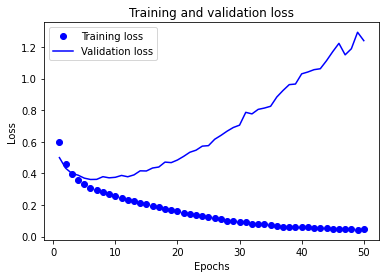

In [74]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

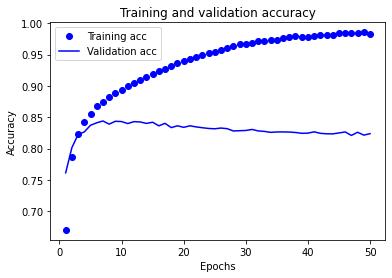

In [75]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [80]:
maxlen

41

In [81]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 16로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________


In [82]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/50
229/229 [==============================] - 3s 8ms/step - loss: 0.6931 - accuracy: 0.5026 - val_loss: 0.6917 - val_accuracy: 0.5135
Epoch 2/50
229/229 [==============================] - 1s 6ms/step - loss: 0.6243 - accuracy: 0.6331 - val_loss: 0.5003 - val_accuracy: 0.7651
Epoch 3/50
229/229 [==============================] - 1s 6ms/step - loss: 0.4401 - accuracy: 0.8038 - val_loss: 0.4118 - val_accuracy: 0.8201
Epoch 4/50
229/229 [==============================] - 1s 6ms/step - loss: 0.3794 - accuracy: 0.8363 - val_loss: 0.3855 - val_accuracy: 0.8329
Epoch 5/50
229/229 [==============================] - 1s 6ms/step - loss: 0.3498 - accuracy: 0.8519 - val_loss: 0.3779 - val_accuracy: 0.8370
Epoch 6/50
229/229 [==============================] - 1s 6ms/step - loss: 0.3310 - accuracy: 0.8617 - val_loss: 0.3706 - val_accuracy: 0.8409
Epoch 7/50
229/229 [==============================] - 1s 6ms/step - loss: 0.3167 - accuracy: 0.8689 - val_loss: 0.3670 - val_accuracy: 0.8430
Epoch 

In [84]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(100))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

history_dict = history.history

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 101       
Total params: 1,090,601
Trainable params: 1,090,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
229/229 [==============================] - 4s 12ms/step - loss: 0.5830 - accuracy: 0.6672 - val_loss: 0.4472 - val_accuracy: 0.7975
Epoch 2/50
229/229 [==============================] - 2s 10ms/step - loss: 0.3953 - accuracy: 0.822

In [88]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(100, return_sequences=True))
model.add(tf.keras.layers.LSTM(100))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

history_dict = history.history

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
lstm_9 (LSTM)                (None, 41, 100)           80400     
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_14 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 1,171,001
Trainable params: 1,171,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
229/229 [==============================] - 7s 20ms/step - loss: 0.5280 - accuracy: 0.7150 - val_lo

In [90]:
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(100, return_sequences=True, recurrent_dropout=0.2))
model.add(tf.keras.layers.LSTM(100))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

callbacks = [
    EarlyStopping(monitor='val_loss',
                  patience=5,
                  restore_best_weights=True)
]

# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                   callbacks=callbacks)

results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

history_dict = history.history

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
lstm_13 (LSTM)               (None, 41, 100)           80400     
_________________________________________________________________
lstm_14 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_18 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 101       
Total params: 1,171,001
Trainable params: 1,171,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
229/229 [==============================] - 41s 165ms/step - loss: 0.5125 - accuracy: 0.7337 - val_

In [83]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

history_dict = history.history

1537/1537 - 3s - loss: 0.5763 - accuracy: 0.8269
[0.5762628316879272, 0.8268812298774719]


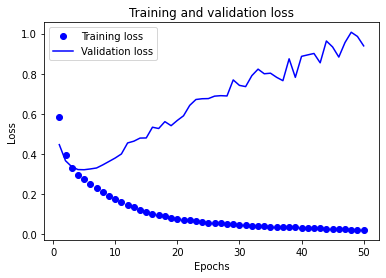

In [85]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

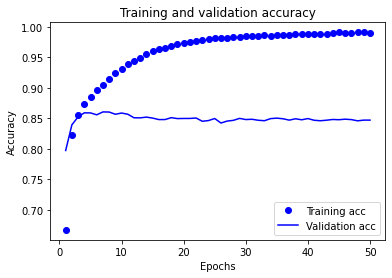

In [86]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()